Import necessary libraries/modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mysumm  # Assuming this is a custom module
import pandas as pd
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from persiantools.jdatetime import JalaliDate  # Library for Jalali calendar
from prophet import Prophet  # Facebook's Prophet forecasting tool
from xgboost import XGBRegressor  # XGBoost regression model

ModuleNotFoundError: No module named 'persiantools'

In [2]:
# Ignore specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning, message="is_sparse is deprecated")
warnings.filterwarnings('ignore', category=FutureWarning, message="The behavior of DatetimeProperties.to_pydatetime is deprecated")
warnings.filterwarnings('ignore', category=FutureWarning, message="is_categorical_dtype is deprecated")

In [3]:
def convert_jalali_to_gregorian(j_date):
    """
    Converts a Jalali date to a Gregorian date.

    Parameters:
        j_date (str): The Jalali date to be converted. It should be in the format 'm/d/y'.

    Returns:
        datetime.date: The converted Gregorian date.

    Raises:
        ValueError: If the Jalali date is invalid.

    Example:
        >>> convert_jalali_to_gregorian('3/15/1400')
        datetime.date(2021, 6, 5)
    """
    j_date_split = j_date.split('/')
    j_year = int(j_date_split[2])
    j_month = int(j_date_split[0])  # Assuming month comes first in your 'm/d/y' format
    j_day = int(j_date_split[1])

    if j_month > 12:
        j_month = 12  # You can choose how to handle an invalid month here

    try:
        g_date = JalaliDate(j_year, j_month, j_day).to_gregorian()
        return g_date
    except ValueError as e:
        print(f"Error converting date '{j_date}': {e}")
        return None

1. Reads an Excel file named "DC-fixed.xlsx" into a
pandas DataFrame called df

2. Converts the 'order_creation_date' column in df from
a Jalali date format to a Gregorian date format.

3. Groups the data in df by 'order_creation_date',
counts the number of 'order_number' entries, and sums
the 'weight_kilograms' values for each group. The result
is stored in a new DataFrame called grouped_data

4. Calls a function create_summary_dataframe
to create a summary DataFrame based
on the grouped data.

5. Calculates the correlation matrix for the numerical
and stores it in
grouped data
correlation matrix.

6. Plots a correlation heatmap using the
correlation_matrix using the seaborn library and
matplotlib.

7. Displays the correlation heatmap.


In [4]:
# Read data from an Excel file into a pandas DataFrame
df = pd.read_excel("DC-fixed.xlsx")

# Convert 'order_creation_date' to Gregorian
df['order_creation_date'] = df['order_creation_date'].apply(convert_jalali_to_gregorian)
df['order_creation_date'] = pd.to_datetime(df['order_creation_date'])

# Grouping and processing data
grouped_data = df.groupby('order_creation_date').agg({'order_number': 'count', 'weight_kilograms': 'sum'}).reset_index()
grouped_data['order_creation_date'] = pd.to_datetime(grouped_data['order_creation_date'])

# Summary DataFrame
summary_df = mysumm.create_summary_dataframe(df)
summary_df

,order_number,recipient_city,recipient_province,sender_city,sender_province,weight_kilograms
Count,381495,381495,381495,381495,381495,381495
Unique_Count,8,822,31,120,31,1139
Unique_Count (%),0.0%,0.2%,0.0%,0.0%,0.0%,0.3%
Missing,0,0,338,0,0,289
Missing (%),0.0%,0.0%,0.1%,0.0%,0.0%,0.1%
Skewness,-233.451672,NaN,NaN,NaN,NaN,12.781244
Kurtosis,54498.95673,NaN,NaN,NaN,NaN,230.322847
Mean,10099815398768.316406,NaN,NaN,NaN,NaN,10.298668
Minimum,2222271688,NaN,NaN,NaN,NaN,0.5
Maximum,10100000000000,NaN,NaN,NaN,NaN,999.0


In [5]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_creation_date  360 non-null    datetime64[ns]
 1   order_number         360 non-null    int64         
 2   weight_kilograms     360 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.6 KB


In [6]:
summary_grouped_data = mysumm.create_summary_dataframe(grouped_data)
summary_grouped_data

,order_number,weight_kilograms
Count,360,360
Unique_Count,309,358
Unique_Count (%),85.8%,99.4%
Missing,0,0
Missing (%),0.0%,0.0%
Skewness,4.093445,-0.23292
Kurtosis,46.946897,-0.61752
Mean,1059.708333,10905.317222
Minimum,12,38.5
Maximum,9793,27781.4


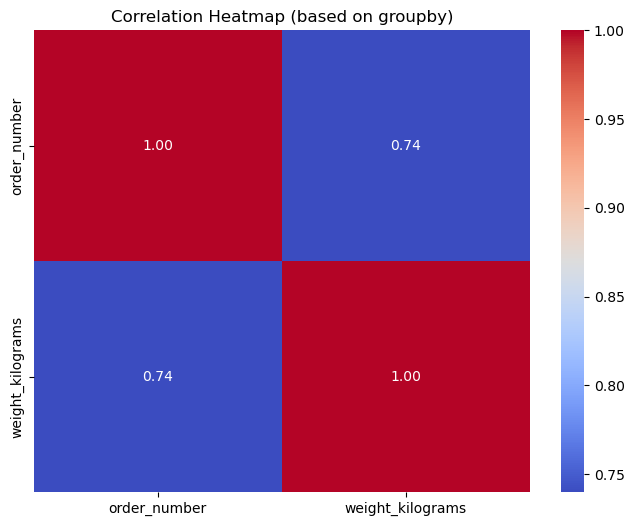

In [7]:
# Correlation heatmap
numerical_columns = grouped_data.select_dtypes(include=['number']).columns.tolist()
correlation_matrix = grouped_data[numerical_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (based on groupby)')
plt.show()

This code defines a function plot_data that takes in data, x
and y column names, a title, and x and y labels. It uses the
library to create a plot with the specified data
matplotlib
and labels.
The code then uses this function to plot monthly order
numbers, monthly weight, and the daily distribution of order
creation dates.

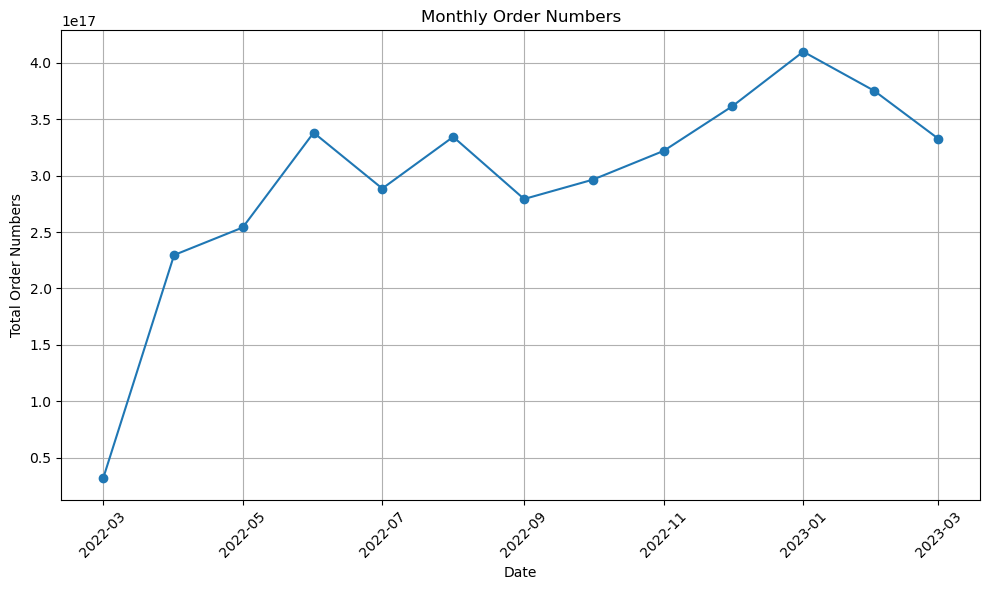

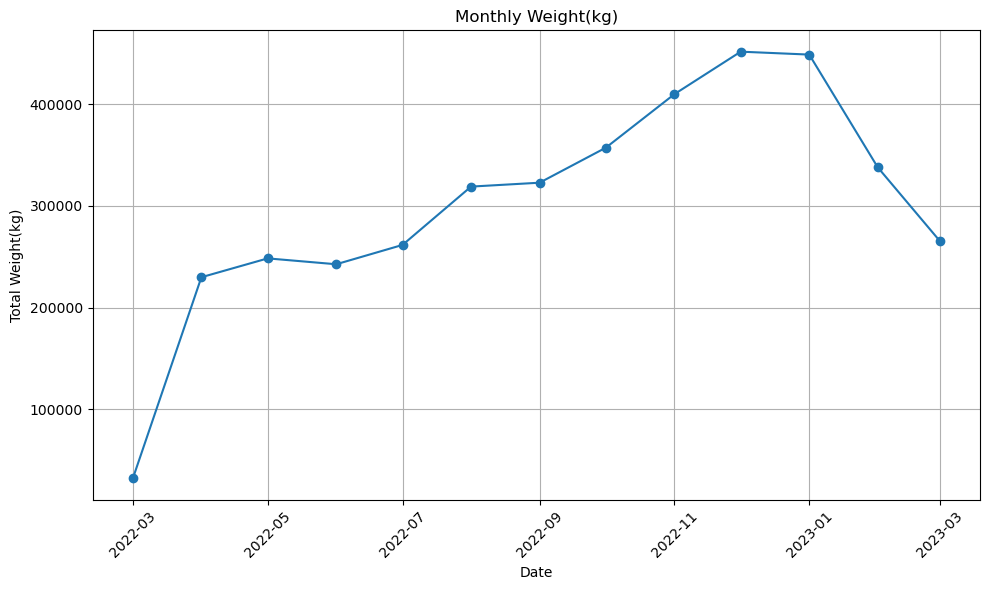

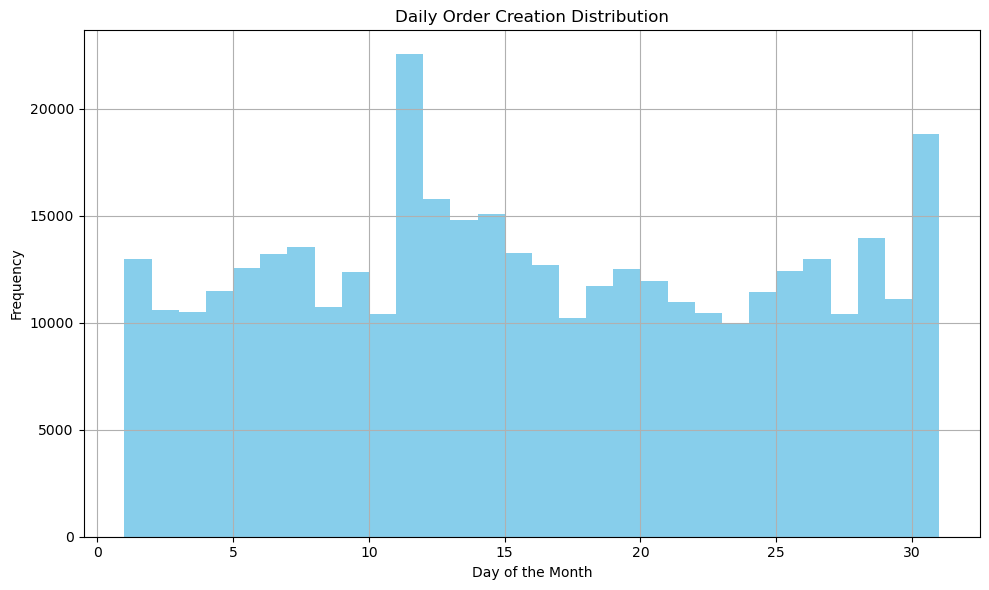

In [8]:
def plot_data(data, x_col, y_col, title, x_label, y_label):
    plt.figure(figsize=(10, 6))
    plt.plot(data[x_col], data[y_col], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Monthly order numbers plot
monthly_order_data = df.groupby(pd.Grouper(key='order_creation_date', freq='MS'))['order_number'].sum().reset_index()
plot_data(monthly_order_data, 'order_creation_date', 'order_number', 'Monthly Order Numbers', 'Date', 'Total Order Numbers')

# Monthly weight plot
monthly_weight_data = df.groupby(pd.Grouper(key='order_creation_date', freq='MS'))['weight_kilograms'].sum().reset_index()
plot_data(monthly_weight_data, 'order_creation_date', 'weight_kilograms', 'Monthly Weight(kg)', 'Date', 'Total Weight(kg)')

# Daily distribution plot
plt.figure(figsize=(10, 6))
df['order_creation_date'].dt.day.plot(kind='hist', bins=30, color='skyblue')  # Adjust bins as needed
plt.title('Daily Order Creation Distribution')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

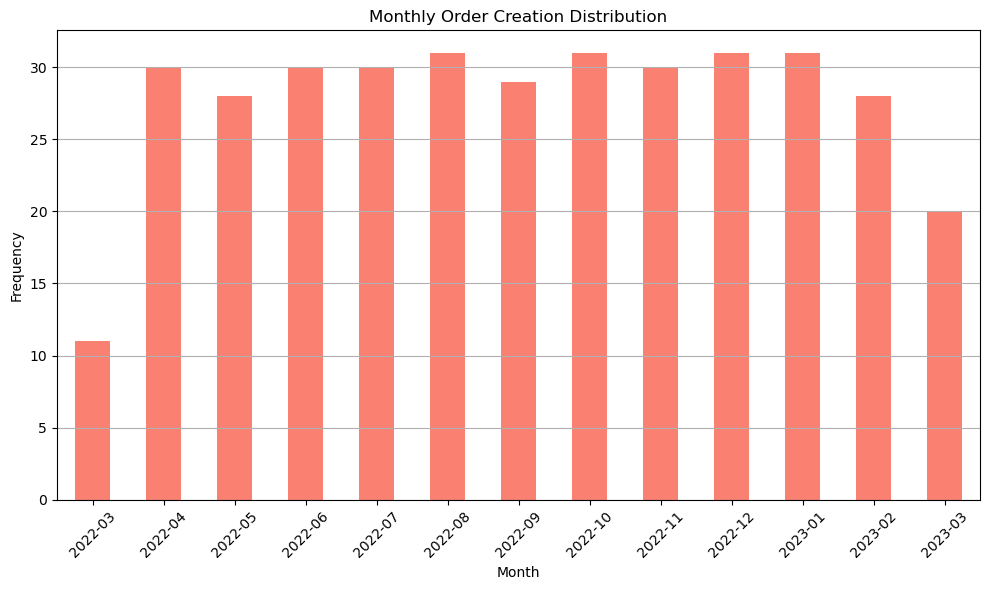

In [9]:
# Plotting monthly distribution
monthly_counts = grouped_data['order_creation_date'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar', color='salmon')
plt.title('Monthly Order Creation Distribution')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The code snippet drops the column 'weight_kilograms' from the DataFrame 'grouped_data', and then assigns the resulting DataFrame to two new variables 'daily_data_Xgboost' and 'daily_data_Prophet'.

In [10]:
grouped_data=grouped_data.drop(columns=['weight_kilograms'])
daily_data_Xgboost = grouped_data
daily_data_Prophet = grouped_data

### This code snippet defines a function prophet_forecast that uses the Prophet library to make time series forecasts.

Here's a breakdown of what the code does:
- It prepares the input data for Prophet by renaming
the columns.
- It initializes a Prophet model and fits it to the data.
- It creates a future dataframe for the specified number
of periods.
- It predicts the values for the specified periods using
the trained model.
- It plots the Prophet forecast, actual values, trend, and
weekly seasonality components.
- It calculates metrics such as R-squared, mean squared
error (MSE), and mean absolute error (MAE) to evaluate
the forecast.
- Finally, it returns the forecast plot, Prophet model,
and forecast data.
The code assumes that there is a DataFrame named
daily_data_Prophet containing columns
'order_creation_date' and 'order_number'.

00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:02 - cmdstanpy - INFO - Chain [1] done processing


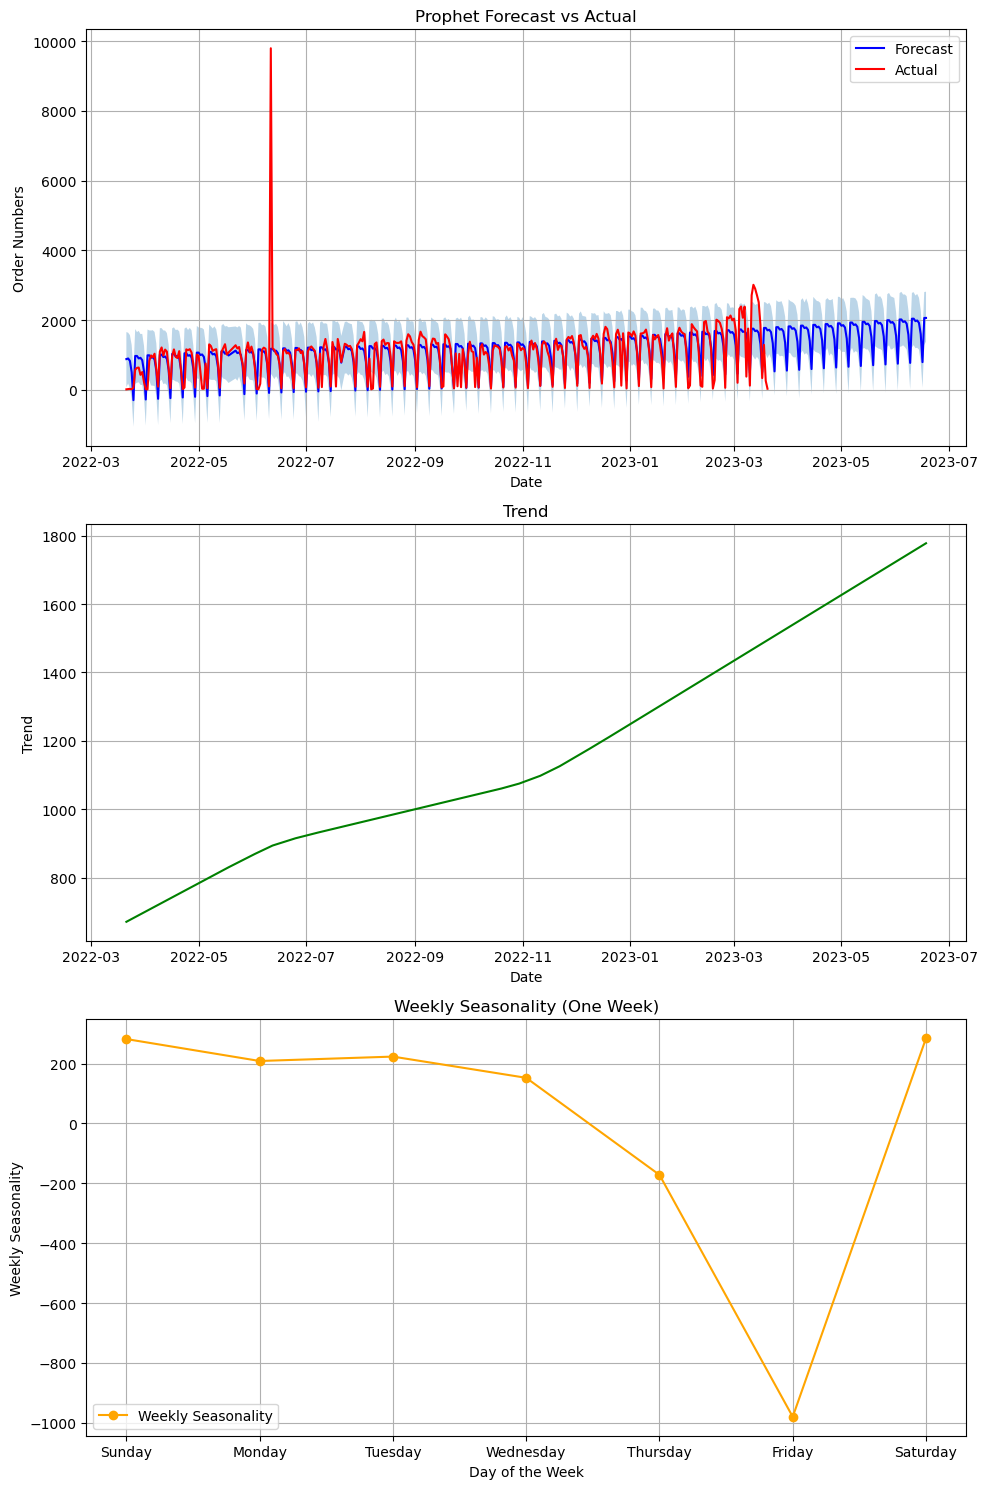

Prophet Training Metrics:
Mean Absolute Error (MAE): 256.06968166085124
Mean Squared Error (MSE): 352531.73380499514
R-squared (R²): 0.39174705271082944


In [11]:
def prophet_forecast(data, periods=90):
    try:
        # Prepare data for Prophet
        prophet_data = data.rename(columns={'order_creation_date': 'ds', 'order_number': 'y'})

        # Prophet model initialization and fitting
        prophet_model = Prophet()
        prophet_model.fit(prophet_data)

        # Make future dataframe for specified periods
        future = prophet_model.make_future_dataframe(periods=periods)

        # Predict for the specified periods
        forecast = prophet_model.predict(future)

        # Plot Prophet forecast and components
        fig, ax = plt.subplots(3, 1, figsize=(10, 15))

        # Plot Prophet forecast vs actual
        ax[0].plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
        ax[0].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
        ax[0].plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='red')
        ax[0].set_xlabel('Date')
        ax[0].set_ylabel('Order Numbers')
        ax[0].set_title('Prophet Forecast vs Actual')
        ax[0].legend()
        ax[0].grid(True)

        # Plot Prophet trend component
        ax[1].plot(forecast['ds'], forecast['trend'], label='Trend', color='green')
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Trend')
        ax[1].set_title('Trend')
        ax[1].grid(True)

        # Plot weekly seasonality for one week
        if 'weekly' in forecast.columns:
            # Convert date strings to Timestamp objects
            forecast['ds'] = pd.to_datetime(forecast['ds'])

            # Filter data for one week
            start_date = '2023-01-01'
            end_date = '2023-01-07'
            one_week = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

            # Extract day of the week
            day_of_week = one_week['ds'].dt.day_name()

            # Plot one week of weekly seasonality with days of the week on the x-axis
            ax[2].plot(day_of_week, one_week['weekly'], label='Weekly Seasonality', color='orange', marker='o')
            ax[2].set_xlabel('Day of the Week')
            ax[2].set_ylabel('Weekly Seasonality')
            ax[2].set_title('Weekly Seasonality (One Week)')
            ax[2].legend()
            ax[2].grid(True)

        plt.tight_layout()
        plt.show()

        # Calculate metrics - R², MSE, MAE
        actual_values = prophet_data['y'].values
        predicted_values = forecast['yhat'].values[:len(actual_values)]

        r2 = r2_score(actual_values, predicted_values)
        mse = mean_squared_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        print("Prophet Training Metrics:")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared (R²): {r2}")

        return fig, prophet_model, forecast
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

# Assuming 'daily_data_Prophet' is your DataFrame containing 'order_creation_date' and 'order_number'
fig, prophet_model, forecast = prophet_forecast(daily_data_Prophet, periods=90)

### This code snippet defines a function called xgboost_forecast that performs time series forecasting using the XGBoost algorithm.

Here's a high-level overview of what the code does:
- It extracts temporal features from the input data,
such as day of week, day of month, month, and year.
- It then prepares the data for training by separating
the input features (x ) from the target variable ( y ).
- It creates an XGBoost model ( xgb_model ) and trains
it on the training data ( x and
- It predicts the order numbers for the next 'days' using
the trained XGBoost model.
- It calculates evaluation metrics (Mean Absolute Error,
Mean Squared Error, R-squared) for the training data
and prints them.
- It creates a DataFrame ( predicted_dates ) with the
predicted order numbers and corresponding dates.
- Finally, it plots the actual order numbers and the
predicted order numbers for the next 'days' using
matplotlib.
The function is then called with daily_data_Xgboost as the
input data and 90 as the number of days to forecast.

XGBoost Training Metrics:
Mean Absolute Error (MAE): 4.982592659526401
Mean Squared Error (MSE): 56.157698584538075
R-squared (R²): 0.9999031063521336


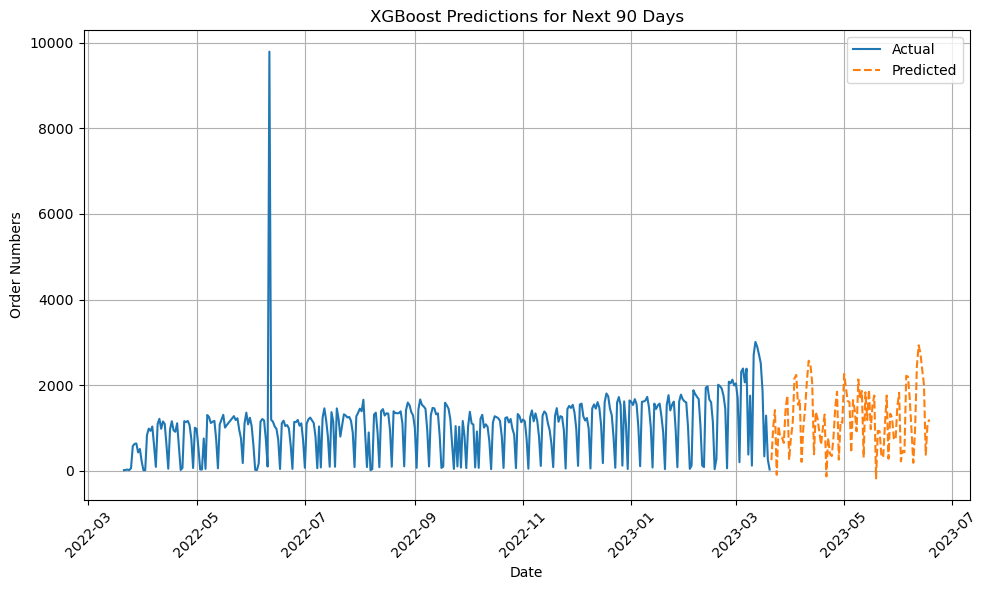

In [12]:
def xgboost_forecast(data, days):

    # Extract temporal features
    data['day_of_week'] = data['order_creation_date'].dt.dayofweek
    data['day_of_month'] = data['order_creation_date'].dt.day
    data['month'] = data['order_creation_date'].dt.month
    data['year'] = data['order_creation_date'].dt.year

    # Drop the original datetime column
    data_clean = data.drop(columns=['order_creation_date'])

    # Training data
    X = data_clean.drop(columns=['order_number'])
    y = data_clean['order_number']

    # Create and train XGBoost model
    xgb_model = XGBRegressor()
    xgb_model.fit(X, y)

    # Predict for the next 'days' using XGBoost
    last_date = data['order_creation_date'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days, freq='D')

    # Create 'future_X' DataFrame including the same features used in training
    future_X = pd.DataFrame({'order_creation_date': future_dates})
    future_X['order_creation_date'] = pd.to_datetime(future_X['order_creation_date'])

    # Extract the same temporal features from 'future_X' as from the training data
    future_X['day_of_week'] = future_X['order_creation_date'].dt.dayofweek
    future_X['day_of_month'] = future_X['order_creation_date'].dt.day
    future_X['month'] = future_X['order_creation_date'].dt.month
    future_X['year'] = future_X['order_creation_date'].dt.year

    # Drop the datetime column in 'future_X'
    future_X = future_X.drop(columns=['order_creation_date'])

    # Making predictions
    xgb_predictions = xgb_model.predict(future_X)

    # Calculate evaluation metrics
    xgb_preds_train = xgb_model.predict(X)
    xgb_mae_train = mean_absolute_error(y, xgb_preds_train)
    xgb_mse_train = mean_squared_error(y, xgb_preds_train)
    xgb_r2_train = r2_score(y, xgb_preds_train)

    print("XGBoost Training Metrics:")
    print(f"Mean Absolute Error (MAE): {xgb_mae_train}")
    print(f"Mean Squared Error (MSE): {xgb_mse_train}")
    print(f"R-squared (R²): {xgb_r2_train}")

    # Create a DataFrame for future predictions with dates
    predicted_dates = pd.DataFrame({'order_creation_date': future_dates, 'order_number_pred': xgb_predictions})

    # Plotting predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(data['order_creation_date'], data['order_number'], label='Actual')
    plt.plot(predicted_dates['order_creation_date'], predicted_dates['order_number_pred'], label='Predicted', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Order Numbers')
    plt.title(f'XGBoost Predictions for Next {days} Days')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

xgboost_forecast(daily_data_Xgboost, 90)